# Setup

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rc = {
    "font.family": "serif",
    "font.size": 10,
    "axes.axisbelow": True,
    "grid.linestyle": '--',
    "axes.grid": True,
    "mathtext.fontset": "cm",
    "grid.alpha": 0.3,
    "text.usetex": True
}

# plt.rcParams.keys
plt.rcParams.update(rc)


# Data prep

In [96]:
from q_factor import get_q_df


In [97]:
q_values = get_q_df('./data_in/QVALUES.txt')

q_values['Q'] = q_values['Q'] * 1

q_values


,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,164.860


# Testing the numerical methods



## Behavior without $Q$ instability

In [98]:
from q_factor import q_func_polynomial
from methods import secant, mod_secant, bisection


In [99]:
def build_test(test_dict: dict,
               q_values: pd.DataFrame,
               q_func_polynomial: callable,
               method: callable,
               include_q_drop=False):

    a = test_dict['a']
    b = test_dict['b']
    seek = test_dict['seek']
    tol = test_dict['tol']
    MAX_ITER = test_dict['max_iter']

    x = np.arange(0, 1, 1e-3)
    f = q_func_polynomial(x, q_values, deg=9, include_q_drop=include_q_drop)

    results = method(a, b, seek, tol, f, MAX_ITER, debug=True)

    return results


In [100]:
def multiple_seeks_test(start, stop, step, method_label, test_dict_copy, *args, **kwargs):
    multiple_seeks = np.arange(start, stop, step)
    m_seeks_records = []

    for seek in multiple_seeks:
        test_dict_copy['seek'] = seek
        
        m_seeks_dict = dict()

        r = build_test(*args, **kwargs)

        m_seeks_dict['Method'] = method_label
        m_seeks_dict['Seek'] = seek
        m_seeks_dict['Iters-to-converge'] = r['iter'].iat[-1]
        m_seeks_dict['c'] = r['c'].iat[-1]
        m_seeks_dict['f(c)'] = r['f(c)'].iat[-1]

        m_seeks_records.append(m_seeks_dict)

    return pd.DataFrame(m_seeks_records)


In [101]:
def get_mock_y(include_q_drop):
  x = np.arange(0, 1, 1e-3)
  f = q_func_polynomial(x, q_values, include_q_drop=include_q_drop)
  y = f(x)

  return y


In [102]:
test_dict = {
    'a': 0.0,
    'b': 1.0,
    'seek': 110,
    'tol': 1,
    'max_iter': 32
}

mock_dict = {
  'x': np.arange(0, 1, 1e-3),
  'y': get_mock_y(include_q_drop=False),
  'y_with_drop': get_mock_y(include_q_drop=True),
}

test_dict_copy = test_dict.copy()

/tmp/ipykernel_40768/1742801971.py:3: RankWarning: Polyfit may be poorly conditioned
  f = q_func_polynomial(x, q_values, include_q_drop=include_q_drop)
/tmp/ipykernel_40768/1742801971.py:3: RankWarning: Polyfit may be poorly conditioned
  f = q_func_polynomial(x, q_values, include_q_drop=include_q_drop)


In [103]:
res_secant = build_test(test_dict, q_values,
                        q_func_polynomial,
                        secant,
                        include_q_drop=False)

res_mod_sec = build_test(test_dict,
                         q_values,
                         q_func_polynomial,
                         mod_secant,
                         include_q_drop=False)

res_bisect = build_test(test_dict,
                        q_values,
                        q_func_polynomial,
                        bisection,
                        include_q_drop=False)


In [104]:
res_secant.tail()

,iter,a,b,c,f(c),error
6,7,0.523456,0.973731,0.643685,74.313694,-35.686306
7,8,0.973731,0.643685,0.711124,87.462432,-22.537568
8,9,0.643685,0.711124,0.826718,126.652723,16.652723
9,10,0.711124,0.826718,0.777600,107.326038,-2.673962
10,11,0.826718,0.777600,0.784396,109.773166,-0.226834


In [105]:
res_mod_sec.tail()

,iter,a,b,c,f(c),error
0,1,0.8000,1.00000,0.794300,113.472012,3.472012
1,2,1.0000,0.79430,0.790750,112.128409,2.128409
2,3,0.7943,0.79075,0.785127,110.040818,0.040818


In [106]:
res_bisect.tail()

,iter,a,b,c,f(c),error
3,4,0.75000,0.875000,0.812500,120.669071,10.669071
4,5,0.75000,0.812500,0.781250,108.631164,-1.368836
5,6,0.78125,0.812500,0.796875,114.458810,4.458810
6,7,0.78125,0.796875,0.789062,111.496587,1.496587
7,8,0.78125,0.789062,0.785156,110.051674,0.051674


In [107]:
def single_to_tex(df, fname):
  ctotex=['Iteração',r'$a$', r'$b$', r'$c$', r'$f(c)$', r'$\varepsilon$']

  df.to_latex(f'./tabs/{fname}.tex', 
                      index=False, 
                      column_format='cccccc', 
                      header=ctotex,
                      escape=False
                      )
  

In [108]:
single_to_tex(res_bisect, 'res-bisect-single')
single_to_tex(res_secant, 'res-secant-single')
single_to_tex(res_mod_sec, 'res-modsec-single')

/tmp/ipykernel_40768/3187586720.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(f'./tabs/{fname}.tex',


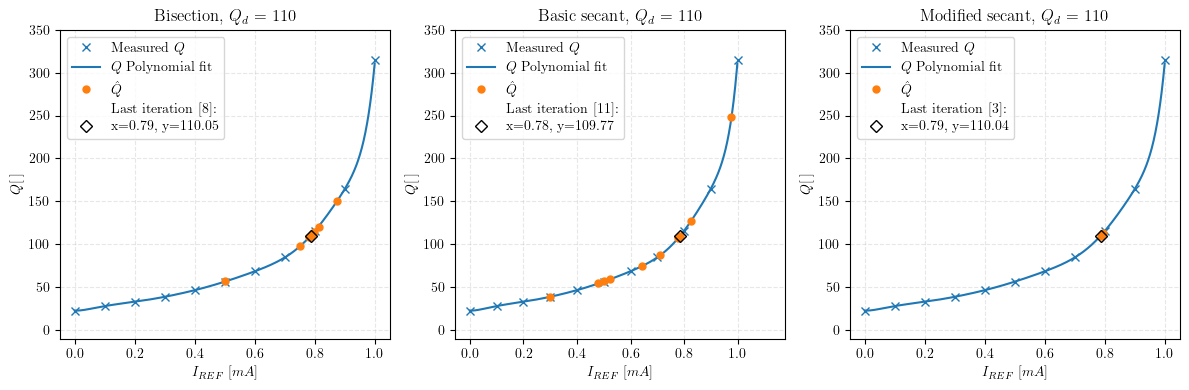

In [109]:
nc = 3
results = [res_bisect, res_secant, res_mod_sec]
titles = ['Bisection','Basic secant', 'Modified secant',]

fig, ax = plt.subplots(ncols=nc, figsize=(12, 4))

for i in range(nc):
    ax[i].plot(q_values['i_ref'],
               q_values['Q'],
               'x', label='Measured $Q$')

    ax[i].plot(mock_dict['x'],
               mock_dict['y'],
               label='$Q$ Polynomial fit', c='C0')

    ax[i].plot(results[i]['c'],
               results[i]['f(c)'],
               'o', markersize=5, label='$\hat{Q}$')

    last_iref = results[i]['c'].iat[-1]
    last_q = results[i]['f(c)'].iat[-1]
    last_iter = results[i]['iter'].iat[-1]

    ax[i].plot(last_iref,
               last_q,
               'D',
               label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
               c='k', fillstyle='none',)

    ax[i].set(
        title=titles[i] + f', $Q_d$ = {test_dict["seek"]}',
        xlabel=r'$I_{REF} \;[mA]$',
        ylabel=r'$Q [\;]$',
        ylim=[-10, 350]
    )
    
for a in ax.flat:
    a.legend()

fig.tight_layout()
fig.savefig('res-methods-single.pdf')

In [110]:
start = 30
stop = 300
step = 20

test_dict_copy['tol'] = test_dict['tol']
# test_dict_copy['tol'] = 1e-6

multiple_secant = multiple_seeks_test(
    start, stop, step, 
    'Basic secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, secant)

multiple_mod_sec = multiple_seeks_test(
    start, stop, step, 
    'Modified secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, mod_secant)

multiple_bisection = multiple_seeks_test(
    start, stop, step, 
    'Bisection', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, bisection)


full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
full_sweep['c'] = (full_sweep['c']).round(3)


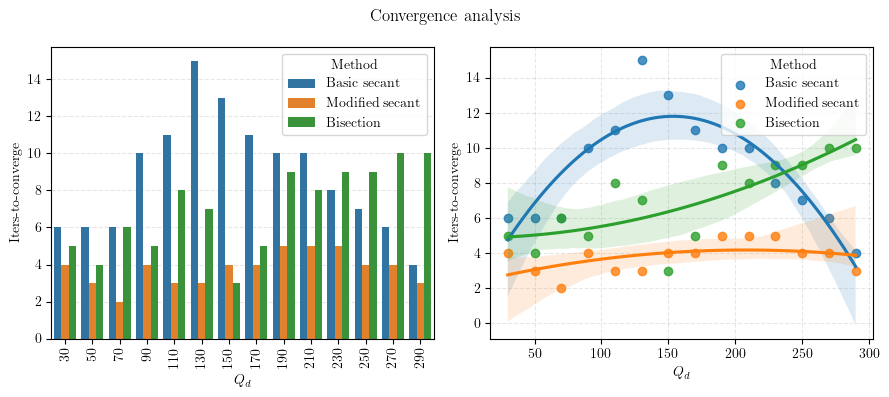

In [111]:
fig, ax = plt.subplots(figsize=(9, 4), ncols=2)

sns.barplot(data=full_sweep,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=full_sweep['Seek'].unique())


sns.regplot(data=multiple_secant, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Basic secant')

sns.regplot(data=multiple_mod_sec, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Modified secant')

sns.regplot(data=multiple_bisection, x='Seek', y='Iters-to-converge',
                        ax=ax[1], order=2, label='Bisection')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')

for ax in ax.flat:
  ax.set(xlabel=r'$Q_d$')

fig.tight_layout()

fig.savefig('conv-analysis-no-drop.pdf')


plt.show()


In [112]:
full_sweep

,Method,Seek,Iters-to-converge,c,f(c)
0,Basic secant,30,6,0.149,29.832808
1,Basic secant,50,6,0.439,50.110039
2,Basic secant,70,6,0.617,70.535629
3,Basic secant,90,10,0.721,89.884930
4,Basic secant,110,11,0.784,109.773166
5,Basic secant,130,15,0.835,130.094690
6,Basic secant,150,13,0.874,149.503841
7,Basic secant,170,11,0.907,169.629260
8,Basic secant,190,10,0.931,189.382226
9,Basic secant,210,10,0.949,209.927138


In [113]:
stats_no_drop = pd.pivot_table(full_sweep.loc[:, ['Iters-to-converge', 'Method']], index='Method' ,aggfunc=[np.min, np.max, np.mean, np.std, np.var])

stats_no_drop.to_latex('./tabs/stats')

/tmp/ipykernel_40768/3431914054.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stats_no_drop.to_latex('./tabs/stats')


## Behavior with $Q$ instability

In [114]:
q_values_drop = get_q_df('./data_in/QVALUES.txt', True, 0.9)

q_values_drop

,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,20.000


In [115]:
test_dict['seek'] = 110


In [116]:
start = 30
stop = 130
step = 10

test_dict_copy['tol'] = test_dict['tol']
# test_dict_copy['tol'] = 1e-6

multiple_secant = multiple_seeks_test(
    start, stop, step, 
    'Basic secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, secant)

multiple_mod_sec = multiple_seeks_test(
    start, stop, step, 
    'Modified secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, mod_secant)

multiple_bisection = multiple_seeks_test(
    start, stop, step, 
    'Bisection', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, bisection)


full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
full_sweep['c'] = (full_sweep['c']).round(3)


In [117]:
res_secant = build_test(test_dict, 
                        q_values_drop,
                        q_func_polynomial,
                        secant,
                        include_q_drop=True)

res_mod_sec = build_test(test_dict,
                         q_values_drop,
                         q_func_polynomial,
                         mod_secant,
                         include_q_drop=True)

res_bisect = build_test(test_dict,
                        q_values_drop,
                        q_func_polynomial,
                        bisection,
                        include_q_drop=True)


/home/pesadaum/work/tcc/src/code/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)


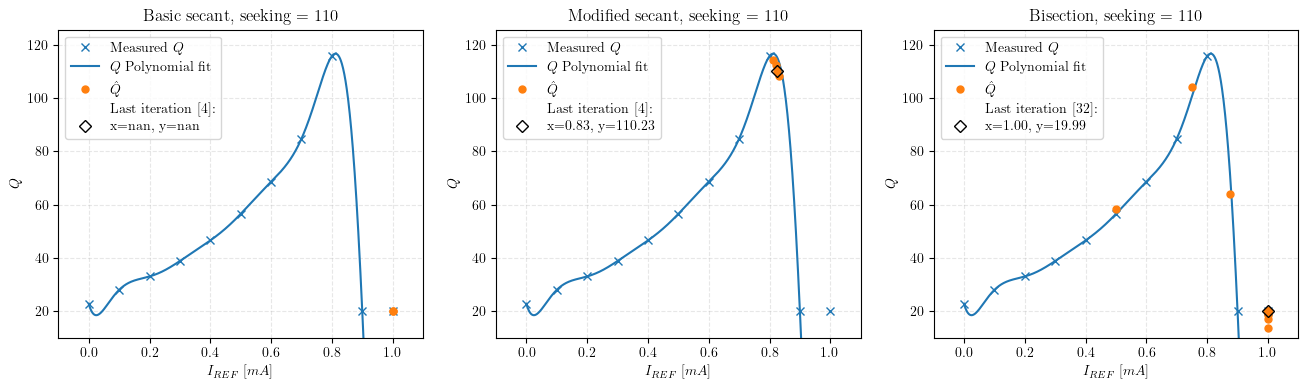

In [118]:
nc = 3
results = [res_secant, res_mod_sec, res_bisect]
titles = ['Basic secant', 'Modified secant', 'Bisection']

fig, ax = plt.subplots(ncols=nc, figsize=(16, 4))

for i in range(nc):
    ax[i].plot(q_values_drop['i_ref'],
               q_values_drop['Q'],
               'x', label='Measured $Q$')

    ax[i].plot(mock_dict['x'],
               mock_dict['y_with_drop'],
               label='$Q$ Polynomial fit', c='C0')

    ax[i].plot(results[i]['c'],
               results[i]['f(c)'],
               'o', markersize=5, label='$\hat{Q}$')

    last_iref = results[i]['c'].iat[-1]
    last_q = results[i]['f(c)'].iat[-1]
    last_iter = results[i]['iter'].iat[-1]

    ax[i].plot(last_iref,
               last_q,
               'D',
               label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
               c='k', fillstyle='none',)

    ax[i].set(
        title=titles[i] + f', seeking = {test_dict["seek"]}',
        xlabel='$I_{REF} \;[mA]$',
        ylabel='$Q$',
        ylim=[10, q_values_drop['Q'].max() + 10],
        xlim=[-0.1, 1.1]
    )

for a in ax.flat:
    a.legend()


In [119]:
# start = 30
# stop = 300
# step = 20

# test_dict_copy['tol'] = test_dict['tol']
# # test_dict_copy['tol'] = 1e-6

# multiple_secant = multiple_seeks_test(
#     start, stop, step,
#     'Basic secant', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, secant)

# multiple_mod_sec = multiple_seeks_test(
#     start, stop, step,
#     'Modified secant', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, mod_secant)

# multiple_bisection = multiple_seeks_test(
#     start, stop, step,
#     'Bisection', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, bisection)


# full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
# full_sweep['c'] = (full_sweep['c']).round(3)
# full_sweep = full_sweep.dropna()


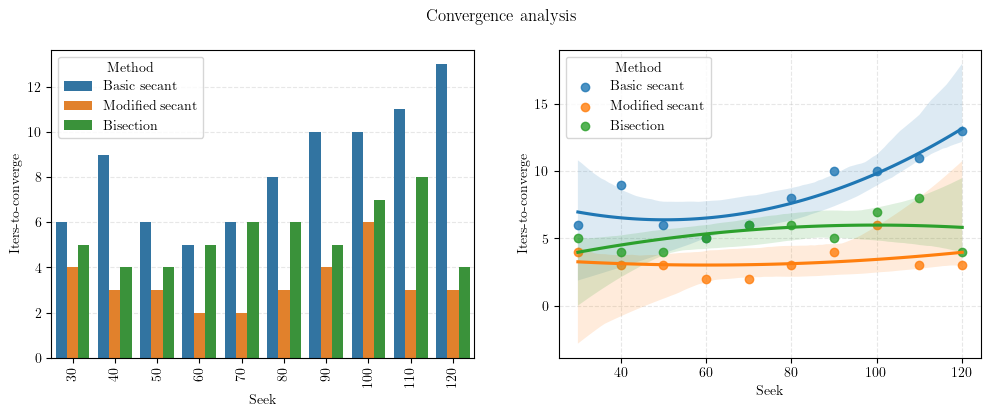

In [120]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

sns.barplot(data=full_sweep,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=full_sweep['Seek'].unique())


sns.regplot(data=multiple_secant, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Basic secant')

sns.regplot(data=multiple_mod_sec, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Modified secant')

sns.regplot(data=multiple_bisection, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Bisection')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')


plt.show()


In [121]:
full_sweep

,Method,Seek,Iters-to-converge,c,f(c)
0,Basic secant,30,6,0.149,29.832808
1,Basic secant,40,9,0.319,40.059873
2,Basic secant,50,6,0.439,50.110039
3,Basic secant,60,5,0.524,59.463388
4,Basic secant,70,6,0.617,70.535629
5,Basic secant,80,8,0.675,79.678458
6,Basic secant,90,10,0.721,89.884930
7,Basic secant,100,10,0.755,99.643467
8,Basic secant,110,11,0.784,109.773166
9,Basic secant,120,13,0.810,119.847317


In [122]:
# def export_decimal_data(n_bits,  fname, *args, **kwargs, drop_):
#   x = np.linspace(0, 1, 2**n_bits-1)
#   f = q_func_polynomial(x, *args, **kwargs)
#   y = f(x)

#   df = pd.DataFrame({'x': x, 'y': y})



In [123]:
x_save = np.linspace(0, 1, 2**10-1)
f_x_save = q_func_polynomial(x_save, q_values, include_q_drop=True)
y_save = f_x_save(x_save)

y_save[850:] = 20 + np.random.randint(0, 10)


/tmp/ipykernel_40768/2058193524.py:2: RankWarning: Polyfit may be poorly conditioned
  f_x_save = q_func_polynomial(x_save, q_values, include_q_drop=True)


In [124]:
fname = 'q_fit_10bits_with_drop.txt'
np.savetxt(fname, y_save.astype(int), fmt='%d')


In [125]:
y_save[:-3]

array([22.709     , 22.32305469, 21.95958175, ..., 21.        ,
       21.        , 21.        ])

# HDL

In [131]:
hdl_bi = pd.read_csv('./q-110-tol-1-hdl-bisection.txt', header=None)
hdl_bi = hdl_bi.iloc[::2, 1:3]
# hdl_bi = hdl_bi[]

hdl_bi.columns = ['I_REF', 'Q']

hdl_bi = hdl_bi.drop_duplicates()

hdl_bi = hdl_bi.iloc[1:, :]
hdl_bi = hdl_bi.astype(int)
hdl_bi['I_REF [mA]'] = hdl_bi['I_REF']/1023
hdl_bi = hdl_bi.loc[:, ['I_REF', 'I_REF [mA]', 'Q']]

hdl_bi

,I_REF,I_REF [mA],Q
2,511,0.499511,56
6,767,0.749756,97
10,895,0.874878,151
14,831,0.812317,121
18,799,0.781036,108
22,815,0.796676,114
26,807,0.788856,111
30,803,0.784946,110


In [133]:
hdl_bi.to_latex(f'./tabs/res-bisect-single-hdl.tex', 
                      index=False, 
                      column_format='ccc', 
                      header=[r'$I_{REF} \; [bits]$', 
                              r'$I_{REF} \; [mA]$', 
                              r'$Q_m$'],
                      escape=False
                      )

/tmp/ipykernel_40768/3759638650.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  hdl_bi.to_latex(f'./tabs/res-bisect-single-hdl.tex',


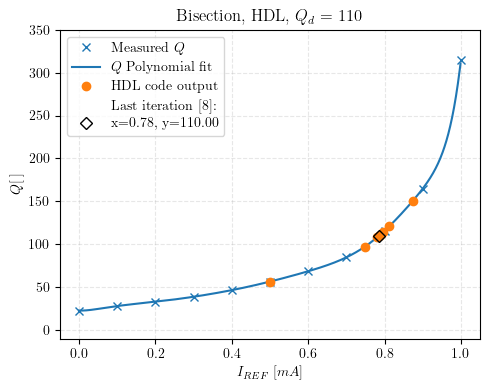

In [134]:
# nc = 3
# results = [res_bisect, res_secant, res_mod_sec]
# titles = ['Bisection','Basic secant', 'Modified secant',]

fig, ax = plt.subplots(figsize=(5, 4))


ax.plot(q_values['i_ref'],
            q_values['Q'],
            'x', label='Measured $Q$')

ax.plot(mock_dict['x'],
            mock_dict['y'],
            label='$Q$ Polynomial fit', c='C0')

ax.plot(hdl_bi['I_REF [mA]'], hdl_bi['Q'], 'o', c='C1', label='HDL code output',)


last_iref = hdl_bi['I_REF [mA]'].iat[-1]
last_q = hdl_bi['Q'].iat[-1]
last_iter = len(hdl_bi)

ax.plot(last_iref,
        last_q,
        'D',
        label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
        c='k', fillstyle='none',)

ax.set(
    title='Bisection, HDL' + f', $Q_d$ = {test_dict["seek"]}',
    xlabel=r'$I_{REF} \;[mA]$',
    ylabel=r'$Q [\;]$',
    ylim=[-10, 350]
)

ax.legend()

fig.tight_layout()
fig.savefig('res-bisect-single-hdl.pdf')

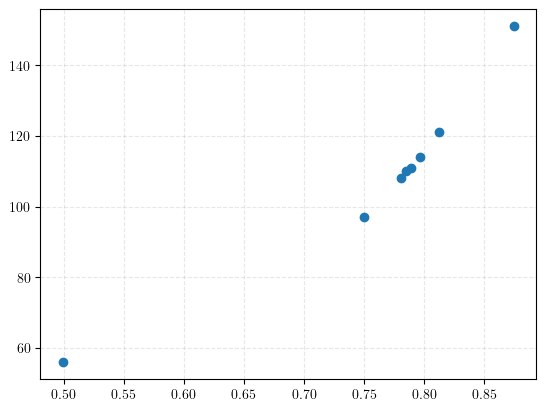

In [129]:


plt.scatter(hdl_bi['I_REF [mA]'], hdl_bi['Q'])

<AxesSubplot: >

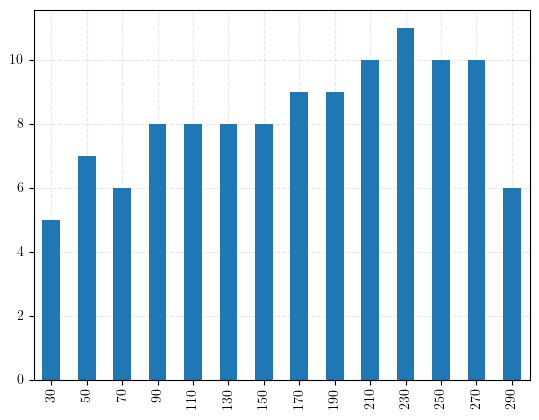

In [200]:
full_sweep_hdl = pd.read_csv('q-sweep-bisect-hdl.txt', header=None)
full_sweep_hdl = full_sweep_hdl.iloc[:, 1:4]
full_sweep_hdl.columns = ['I_REF', 'Q', 'Q_D']
full_sweep_hdl['Q_D'] = full_sweep_hdl['Q_D'].astype(int)
full_sweep_hdl = full_sweep_hdl[full_sweep_hdl['I_REF'] != full_sweep_hdl.loc[0, 'I_REF']]
full_sweep_hdl = full_sweep_hdl.iloc[1::4, :]

# full_sweep_hdl = full_sweep_hdl.iloc[::4, :]


full_sweep_hdl['Q_D'].value_counts().sort_index().plot.bar()
# full_sweep_hdl['I_REF [mA]'] = full_sweep_hdl['I_REF']/1024
# full_sweep_hdl = full_sweep_hdl.loc[:, ['I_REF', 'I_REF [mA]', 'Q', 'Q_d']]

# full_sweep_hdl.head(50)

,I_REF,Q,Q_D
1,511,x,30
5,255,56,30
9,127,35,30
13,191,29,30
17,159,32,30
22,511,56,50
26,255,35,50
30,383,44,50
34,447,49,50
38,479,53,50
